# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/installation.md) before you start.

# Imports

In [7]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
from glob import glob
import pandas as pd
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import time

from object_detection.utils import label_map_util

%matplotlib inline

# Model preparation object_detection

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [2]:
# What model to download.
MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous_coco_11_06_2017'
#MODEL_FILE = MODEL_NAME + '.tar.gz'
#DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = 'object_detection/' + MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('object_detection/data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

## Load a (frozen) Tensorflow model into memory.

In [3]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `3`, we know that this corresponds to `car`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [4]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## Helper code

In [5]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [8]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
# PATH_TO_TEST_IMAGES_DIR = 'test_images'
#PATH_TO_IMAGES_DIR = 'inputs/test/'
#IMAGE_PATHS = glob(PATH_TO_IMAGES_DIR + '*.jpg')

df_train = pd.read_csv('inputs/sample_submission.csv')
IMAGE_PATHS = df_train['img']

In [7]:
def set_coordinates(xmin, ymin, xmax, ymax, img_size):
    margin = 30
    im_width, im_height = img_size
    xmin = int(np.round(xmin*im_width))
    ymin = int(np.round(ymin*im_height))
    xmax = int(np.round(xmax*im_width))
    ymax = int(np.round(ymax*im_height))
    
    xmin = xmin-margin if(xmin-margin>0) else xmin
    ymin = ymin-margin if(ymin-margin>0) else ymin
    xmax = xmax+margin if(xmax+margin<im_width) else xmax
    ymax = ymax+margin if(ymax+margin<im_height) else ymax
    
    return xmin, ymin, xmax, ymax

In [8]:
num = 1
bboxes = []

In [9]:
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    start_time = time.time()
    for image_path in IMAGE_PATHS:
      image = Image.open(os.path.join('inputs/test/'+image_path))
      #The array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
      # Each box represents a part of the image where a particular object was detected.
      boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
      # Each score represent how level of confidence for each of the objects.
      # Score is shown on the result image, together with the class label.
      scores = detection_graph.get_tensor_by_name('detection_scores:0')
      classes = detection_graph.get_tensor_by_name('detection_classes:0')
      num_detections = detection_graph.get_tensor_by_name('num_detections:0')
      # Actual detection.
      (boxes, scores, classes, num_detections) = sess.run(
          [boxes, scores, classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      (ymin, xmin, ymax, xmax) = boxes[0][0]
      #im_width, im_height = image.size
      x1, y1, x2, y2 = set_coordinates(xmin, ymin, xmax, ymax, image.size)
      bboxes.append([image_path, x1, y1, x2, y2])
      if num%100==0:
        print '{0}/{1}--- {2} seconds ---'.format(num, len(IMAGE_PATHS), (time.time() - start_time))
        np.savetxt('inputs/test_bbox_{0}.csv'.format(num), bboxes, fmt='%s', delimiter=',', newline='\n')
        start_time = time.time()
      num += 1
    
np.savetxt('inputs/test_bbox.csv', bboxes, fmt='%s', delimiter=',', newline='\n')
    
      # Visualization of the results of a detection.
      #vis_util.visualize_boxes_and_labels_on_image_array(
      #    image_np,
      #    np.squeeze(boxes),
      #   np.squeeze(classes).astype(np.int32),
      #    np.squeeze(scores),
      #    category_index,
      #    use_normalized_coordinates=True,
      #    line_thickness=8)
      #plt.figure(figsize=IMAGE_SIZE)
      #plt.imshow(image_np)

100/100064--- 215.538383007 seconds ---
200/100064--- 212.188874006 seconds ---
300/100064--- 211.859524012 seconds ---
400/100064--- 212.172161102 seconds ---
500/100064--- 212.088529825 seconds ---
600/100064--- 212.204128027 seconds ---
700/100064--- 212.208400011 seconds ---
800/100064--- 212.410260916 seconds ---
900/100064--- 212.474903822 seconds ---
1000/100064--- 213.508800983 seconds ---
1100/100064--- 214.200098991 seconds ---
1200/100064--- 214.138798952 seconds ---
1300/100064--- 213.703952074 seconds ---
1400/100064--- 214.314575911 seconds ---
1500/100064--- 214.160553932 seconds ---
1600/100064--- 214.430539131 seconds ---
1700/100064--- 214.290660143 seconds ---
1800/100064--- 214.122034073 seconds ---
1900/100064--- 213.594723225 seconds ---
2000/100064--- 213.349678993 seconds ---
2100/100064--- 213.627940893 seconds ---
2200/100064--- 213.669580936 seconds ---
2300/100064--- 213.404278994 seconds ---
2400/100064--- 213.538542986 seconds ---
2500/100064--- 213.339777

20000/100064--- 215.217015028 seconds ---
20100/100064--- 215.575639009 seconds ---
20200/100064--- 215.870686054 seconds ---
20300/100064--- 216.049888849 seconds ---
20400/100064--- 215.416282177 seconds ---
20500/100064--- 215.056651115 seconds ---
20600/100064--- 215.322911024 seconds ---
20700/100064--- 215.090949059 seconds ---
20800/100064--- 214.658681154 seconds ---
20900/100064--- 216.027702093 seconds ---
21000/100064--- 215.406301975 seconds ---
21100/100064--- 215.200304985 seconds ---
21200/100064--- 215.471909046 seconds ---
21300/100064--- 215.954269886 seconds ---
21400/100064--- 216.572624207 seconds ---
21500/100064--- 215.522026062 seconds ---
21600/100064--- 215.440352917 seconds ---
21700/100064--- 214.877191067 seconds ---
21800/100064--- 214.420365095 seconds ---
21900/100064--- 214.610742092 seconds ---
22000/100064--- 214.513604164 seconds ---
22100/100064--- 214.420204878 seconds ---
22200/100064--- 214.538722038 seconds ---
22300/100064--- 214.121443987 seco

39600/100064--- 208.477499008 seconds ---
39700/100064--- 208.136090994 seconds ---
39800/100064--- 207.799679041 seconds ---
39900/100064--- 207.882652044 seconds ---
40000/100064--- 208.292830944 seconds ---
40100/100064--- 208.383261919 seconds ---
40200/100064--- 208.62451005 seconds ---
40300/100064--- 207.564791918 seconds ---
40400/100064--- 208.256198883 seconds ---
40500/100064--- 208.455960035 seconds ---
40600/100064--- 208.648190022 seconds ---
40700/100064--- 207.876538992 seconds ---
40800/100064--- 207.749749899 seconds ---
40900/100064--- 208.330914974 seconds ---
41000/100064--- 207.737122059 seconds ---
41100/100064--- 207.519248962 seconds ---
41200/100064--- 208.015531063 seconds ---
41300/100064--- 208.02265501 seconds ---
41400/100064--- 207.714185953 seconds ---
41500/100064--- 206.940975904 seconds ---
41600/100064--- 207.897776127 seconds ---
41700/100064--- 207.530997038 seconds ---
41800/100064--- 208.670935154 seconds ---
41900/100064--- 210.700793028 second

59200/100064--- 201.07834506 seconds ---
59300/100064--- 200.739213943 seconds ---
59400/100064--- 200.564594984 seconds ---
59500/100064--- 200.767091036 seconds ---
59600/100064--- 201.318836927 seconds ---
59700/100064--- 201.021618128 seconds ---
59800/100064--- 200.379055023 seconds ---
59900/100064--- 200.820364952 seconds ---
60000/100064--- 200.484814167 seconds ---
60100/100064--- 201.008306026 seconds ---
60200/100064--- 199.926705122 seconds ---
60300/100064--- 200.019367933 seconds ---
60400/100064--- 200.669029951 seconds ---
60500/100064--- 200.705275774 seconds ---
60600/100064--- 200.538404942 seconds ---
60700/100064--- 199.812654972 seconds ---
60800/100064--- 200.149860144 seconds ---
60900/100064--- 200.22569108 seconds ---
61000/100064--- 199.991858006 seconds ---
61100/100064--- 200.887665987 seconds ---
61200/100064--- 200.460961103 seconds ---
61300/100064--- 200.157531023 seconds ---
61400/100064--- 199.961474895 seconds ---
61500/100064--- 200.630448818 second

78800/100064--- 204.314834118 seconds ---
78900/100064--- 204.435866117 seconds ---
79000/100064--- 206.230736971 seconds ---
79100/100064--- 204.970947027 seconds ---
79200/100064--- 204.957308054 seconds ---
79300/100064--- 204.666328907 seconds ---
79400/100064--- 205.066837072 seconds ---
79500/100064--- 204.768975973 seconds ---
79600/100064--- 205.095319033 seconds ---
79700/100064--- 204.602400064 seconds ---
79800/100064--- 205.020308971 seconds ---
79900/100064--- 210.803542137 seconds ---
80000/100064--- 215.22022295 seconds ---
80100/100064--- 211.332704067 seconds ---
80200/100064--- 209.868513107 seconds ---
80300/100064--- 205.753096104 seconds ---
80400/100064--- 204.823014975 seconds ---
80500/100064--- 205.025274038 seconds ---
80600/100064--- 203.853205919 seconds ---
80700/100064--- 204.846979141 seconds ---
80800/100064--- 205.248124838 seconds ---
80900/100064--- 204.886023045 seconds ---
81000/100064--- 204.853186131 seconds ---
81100/100064--- 204.743181944 secon

98400/100064--- 207.508948088 seconds ---
98500/100064--- 207.369987011 seconds ---
98600/100064--- 207.077661037 seconds ---
98700/100064--- 207.348621845 seconds ---
98800/100064--- 207.409940958 seconds ---
98900/100064--- 207.989937067 seconds ---
99000/100064--- 207.026736021 seconds ---
99100/100064--- 207.462828159 seconds ---
99200/100064--- 207.421905041 seconds ---
99300/100064--- 207.259053946 seconds ---
99400/100064--- 207.463625908 seconds ---
99500/100064--- 207.995376825 seconds ---
99600/100064--- 207.322179079 seconds ---
99700/100064--- 209.456143141 seconds ---
99800/100064--- 212.487221003 seconds ---
99900/100064--- 212.869216919 seconds ---
100000/100064--- 213.206920147 seconds ---


In [1]:
import pandas as pd
from utils import get_bboxes
from os import path
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
df_train = pd.read_csv('inputs/sample_submission.csv')
IMAGE_PATHS = df_train['img']

bboxes = get_bboxes('inputs/test_bbox.csv')

In [3]:
print IMAGE_PATHS[13]

0004d4463b50_14.jpg


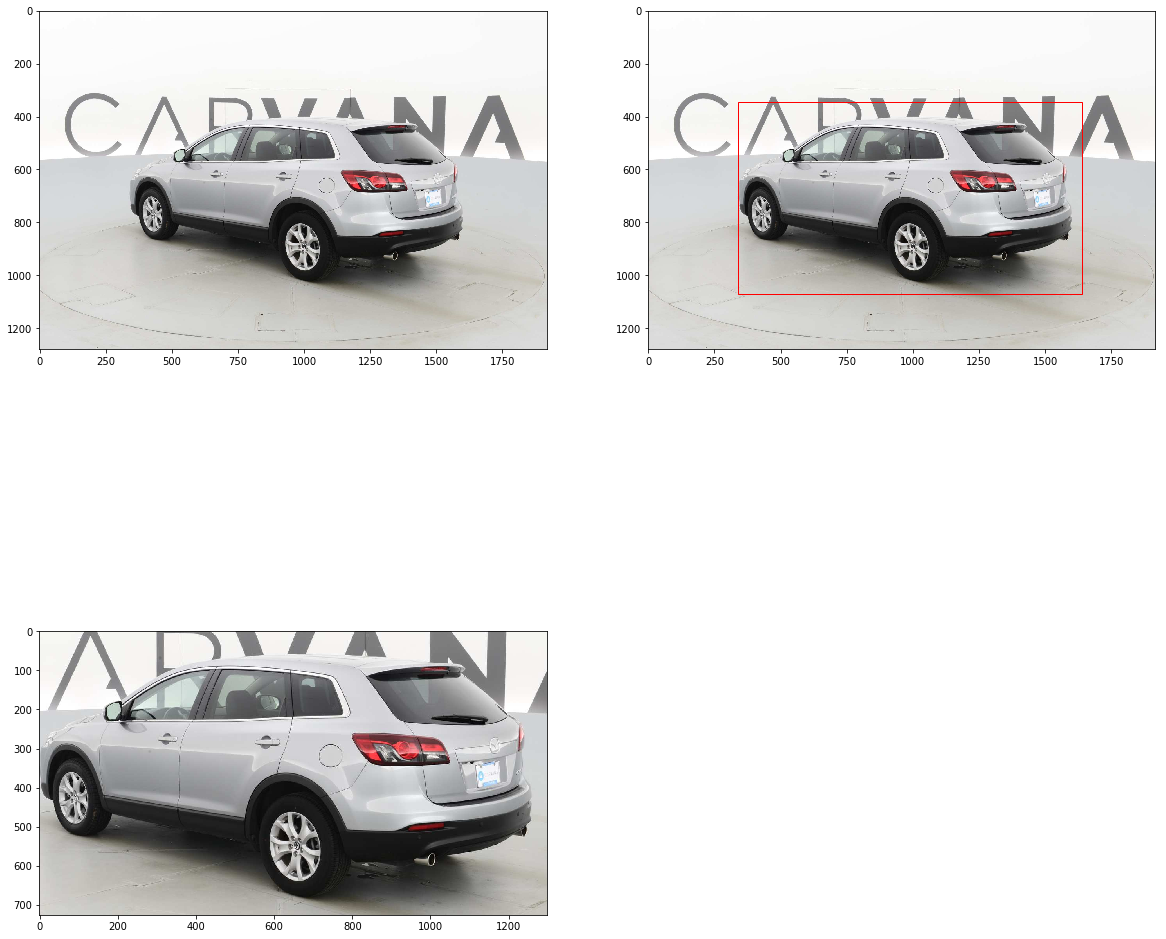

In [57]:
id_img=230

img = np.array(Image.open(path.join('inputs/test/', IMAGE_PATHS[id_img])))
xmin, ymin, xmax, ymax = bboxes[IMAGE_PATHS[id_img]]
cropped_img = img[ymin:ymax, xmin:xmax]

fig = plt.figure(figsize=(20, 20))
sub1 = fig.add_subplot(2, 2, 1)
sub1.imshow(img)
sub2 = fig.add_subplot(2, 2, 2)
sub2.add_patch(plt.Rectangle((xmin, ymin), width=xmax-xmin, height=ymax-ymin, fill=False, color='red')) 
sub2.imshow(img)
sub3 = fig.add_subplot(2, 2, 3)
sub3.imshow(cropped_img)